Import librerie

In [171]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import seaborn as sns
from lime import lime_text
import unicodedata
import pandas as pd
from string import punctuation
import numpy as np
import torch
from nltk.tokenize import word_tokenize
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from torch import optim
from tqdm import tqdm
from sklearn import preprocessing
import time
import random
import torch.nn.functional as F

Import dataset

In [172]:
df = pd.read_excel('../input/ciao9cci/politica.xlsx', sheet_name="Foglio1")
print(f'Found {len(df)} texts.')

print(f'{df["cap_maj_master"].isnull().sum()} document(s) with no classification removed')
df=df[pd.notnull(df['cap_maj_master'])]

print(f'{df["testo"].isnull().sum()} document(s) with no text removed')
df=df[pd.notnull(df['testo'])]

le = preprocessing.LabelEncoder()
le.fit(df['cap_maj_master'])
df['cap_maj_master']=le.transform(df['cap_maj_master'])
classes = [int(c) for c in df['cap_maj_master'].values]
documents = [d for d in df['testo']]

Found 5674 texts.
2 document(s) with no classification removed
424 document(s) with no text removed


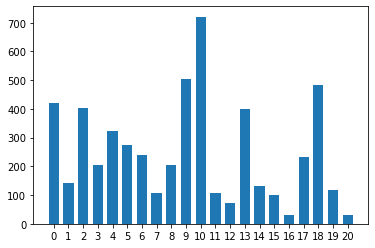

In [173]:
y = np.bincount(classes)
x = np.arange(len(y))
fig, ax = plt.subplots()
plt.bar(x, y,width=0.7)
ax.set_xticks(x)
ax.set_aspect('auto')
plt.show()


preprocessing

In [174]:
def preprocessor(text):
    text = re.sub('<[^>]*>', ' ', str(text))
    #text = re.sub(r'[^\w\s]'," ", text)
    text=re.sub('\d+',' ',str(text))
    text=re.sub('[ﾫﾻ]','',str(text))
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',
                           str(text))
    text = (re.sub('[\W]+', ' ', text.lower().strip()) + ' ' +
            ' '.join(emoticons).replace('-', ''))
    return text

def strip_accents(text):
    """
    Strip accents from input String.

    :param text: The input string.
    :type text: String.

    :returns: The processed String.
    :rtype: String.
    """
    try:
        text = unicode(text, 'utf-8')
    except (TypeError, NameError): # unicode is a default on python 3 
        pass
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore')
    text = text.decode("utf-8")
    return str(text)

stop=set(stopwords.words('italian'))

def tokenizer_porter(text):
    word_tokens = word_tokenize(text)
    stemmer = SnowballStemmer("italian", ignore_stopwords=True)
    return [stemmer.stem(word) for word in word_tokens]
  

def tokenizer(text):
    stop=set(stopwords.words('italian'))
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop]
    filtered_sentence = [w for w in filtered_sentence if len(w)>3]
    return filtered_sentence

In [175]:
def split_words_documents(documents):
    tokenized = documents = [tokenizer(strip_accents(preprocessor(document))) 
                              for document in documents]
    all_text = []
    lenght_text = []
    for tokens in tokenized:
        lenght_text.append(len(tokens))
        for t in tokens:
            all_text.append(t)
    return tokenized, lenght_text, set(all_text)

documents,lenght, vocab = split_words_documents(documents)

In [176]:
print(np.max([len(x) for x in documents]))
print(np.mean([len(x) for x in documents]))

1375
200.98799542682926


In [177]:
vocaboli=set(line.strip() for line in open('../input/prova2/prova.txt'))
vocaboli_more=vocaboli.union(vocab)
print("Aggiunte ",len(vocaboli_more)-len(vocaboli),"/",len(vocab)," parole")

Aggiunte  14648 / 49263  parole


In [178]:
def create_dictionaries(words):
    word_to_int_dict = {w:i+1 for i,w in enumerate(words)}
    int_to_word_dict = {i:w for w,i in word_to_int_dict.items()}
    return word_to_int_dict, int_to_word_dict
word_to_int_dict, int_to_word_dict = create_dictionaries(vocaboli)

In [179]:
def pad_text(tokenized_documents,seq_length):
    documents = []
    for document in tokenized_documents:
        if len(document) >= seq_length:
            documents.append(document[:seq_length])
        else:
            documents.append(['']*(seq_length-len(document))+document)
    return np.array(documents)
padded_sentences = pad_text(documents, seq_length = 700)  

In [180]:
int_to_word_dict[0]=''
word_to_int_dict['']=0

In [181]:
encoded_sentences = np.array([[word_to_int_dict[word] if word in word_to_int_dict else 0 for word in content ] for content in padded_sentences])

In [182]:
print(encoded_sentences.shape)

(5248, 700)


In [183]:
def load_pretrained_vectors(word2idx, fname):
    """Load pretrained vectors and create embedding layers.
    
    Args:
        word2idx (Dict): Vocabulary built from the corpus
        fname (str): Path to pretrained vector file

    Returns:
        embeddings (np.array): Embedding matrix with shape (N, d) where N is
            the size of word2idx and d is embedding dimension
    """

    print("Loading pretrained vectors...")
    fin = open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initilize random embeddings
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['']] = np.zeros((d,))

    # Load pretrained vectors
    count = 0
    for line in tqdm(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.double)

    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")

    return embeddings

In [184]:
# Load pretrained vectors
print("Tokenizing...\n")
embeddings = load_pretrained_vectors(word_to_int_dict, "../input/fasttext-aligned-word-vectors/wiki.it.align.vec")
embeddings = torch.tensor(embeddings)

Tokenizing...

Loading pretrained vectors...


871053it [00:40, 21386.64it/s]


There are 135327 / 279895 pretrained vectors found.


In [185]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 2019

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True 

In [186]:
def create_data_loader(train_c, valid_c, train_l,valid_l,batch_size):
    x_train = torch.tensor(train_c, dtype=torch.long,device=DEVICE)
    y_train = torch.tensor(train_l, dtype=torch.long, device=DEVICE)
    x_cv = torch.tensor(valid_c, dtype=torch.long, device=DEVICE)
    y_cv = torch.tensor(valid_l, dtype=torch.long, device=DEVICE)
    # Create Torch datasets
    train = torch.utils.data.TensorDataset(x_train, y_train)
    valid = torch.utils.data.TensorDataset(x_cv, y_cv)
    # Create Data Loaders
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
    return train_loader, valid_loader
    

In [187]:
def plot_graph(train_loss, valid_loss):
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
    plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

    # find position of lowest validation loss
    minposs = valid_loss.index(min(valid_loss))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    #plt.ylim(0, 0.5) # consistent scale
    #plt.xlim(0, len(train_loss)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [188]:
import numpy as np
import torch
#https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [189]:
class ClassificationCNN(nn.Module):
    
    def __init__(self, 
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 n_vocab=None, 
                 n_embed=300,
                 n_filters=100, 
                 n_output=1, 
                 filter_sizes=[2,3,4], 
                 dropout = 0.8,
                 pad_idx=0.0):
        super().__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.n_vocab, self.n_embed = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        
        
         
        self.dropout = nn.Dropout(dropout)
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = self.n_embed, 
                                              out_channels = n_filters, 
                                              kernel_size = fs) 
                                    for fs in filter_sizes
                                    ])
        
        
        self.fc1 = nn.Linear(len(filter_sizes) * n_filters, n_output)
        
        

        
        
    def forward(self, text):
        
        emb = self.embedding(text)
        emb=emb.transpose(2,1)
        conved = [F.relu(c(emb)) for c in self.convs] 
        #al max_pool1d diamo come parametro il filter size
        pooled = [F.max_pool1d(c, c.shape[2]).squeeze(2) for c in conved]
        concat = self.dropout(torch.cat(pooled, dim = 1))
        return self.fc1(concat)

In [190]:
def evaluate(model, data_loader, criterion):
    model.eval()
    val_accuracy = []
    val_loss = []
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(data_loader):
            logits= model(x_batch)
            loss = criterion(logits, y_batch)
            val_loss.append(loss.item())
            
            _, preds = torch.max(logits, 1)
            accuracy = (preds == y_batch).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)
        val_accuracy = np.mean(val_accuracy)
        return val_loss, val_accuracy

In [191]:
def train(model, optimizer,criterion, train_loader, val_loader=None, patience=7, epochs=10):
    print("Start training...\n")
    print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
    print("-"*60)
    best_accuracy=0
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        t0_epoch = time.time()
        total_loss = 0
        ###################
        # train the model #
        ###################
        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            y_pred= model(x_batch)
            # calculate the loss
            loss = criterion(y_pred, y_batch)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())
            
        ######################    
        # validate the model #
        ###################### 
        valid_losses, val_accuracy = evaluate(model, val_loader,criterion)
        
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        time_elapsed = time.time() - t0_epoch
        print(f"{epoch :^7} | {train_loss:^12.6f} | {valid_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        
    print("\n")
    
    plot_graph(avg_train_losses, avg_valid_losses)
    model.load_state_dict(torch.load('checkpoint.pt'))
    
    return model
    

In [192]:
def pytorch_predict(model, test_loader):
    '''
    Make prediction from a pytorch model 
    '''
    # set model to evaluate model
    model.eval()
    labels=[]
    with torch.no_grad():
        for (text, label) in test_loader:             
            outputs = model(text)
            _, preds = torch.max(outputs, 1)
            for pred in preds:
                labels.append(pred.item())
    
    return labels

In [193]:
batch_size = 128
n_output = len(np.unique(classes))
number_of_filters = 100
filter_sizes = [1,2,3]
dropout_pc = 0.5
n_epochs = 100
nfold=10
patience=5

Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  363.750975  | 288.988208 |   12.81   |   4.31   
Validation loss decreased (inf --> 288.988208).  Saving model ...
   2    |  330.075642  | 257.258283 |   29.69   |   4.33   
Validation loss decreased (288.988208 --> 257.258283).  Saving model ...
   3    |  260.943577  | 201.805148 |   43.55   |   4.34   
Validation loss decreased (257.258283 --> 201.805148).  Saving model ...
   4    |  199.373891  | 172.405582 |   49.90   |   4.37   
Validation loss decreased (201.805148 --> 172.405582).  Saving model ...
   5    |  161.245508  | 153.705929 |   58.87   |   4.31   
Validation loss decreased (172.405582 --> 153.705929).  Saving model ...
   6    |  131.198937  | 143.948692 |   56.11   |   4.33   
Validation loss decreased (153.705929 --> 143.948692).  Saving model ...
   7    |  104.644024  | 138.644229 |   59.36   |   4.31   
Validatio

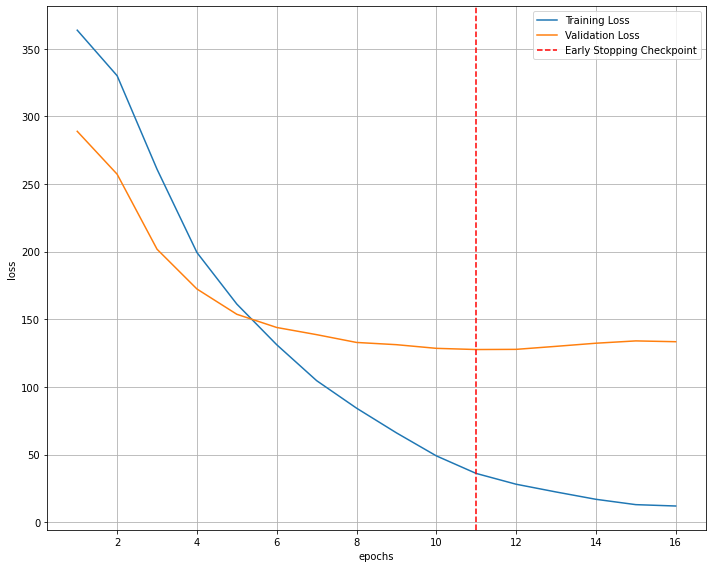

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--------------- Fold:  1 ---------------------

              precision    recall  f1-score   support

           0       0.39      0.62      0.48        42
           1       0.78      0.47      0.58        15
           2       0.86      0.80      0.83        40
           3       0.89      0.76      0.82        21
           4       0.73      0.50      0.59        32
           5       0.89      0.93      0.91        27
           6       0.61      0.71      0.65        24
           7       0.83      0.45      0.59        11
           8       0.88      0.70      0.78        20
           9       0.70      0.80      0.75        50
          10       0.67      0.82      0.74        73
          11       0.57      0.36      0.44        11
          12       1.00      0.29      0.44         7
          13       0.40      0.40      0.40        40
          14       0.92      0.92      0.92        13
          15       0.75      0.30      0.43        10
          16       0.00      0.00

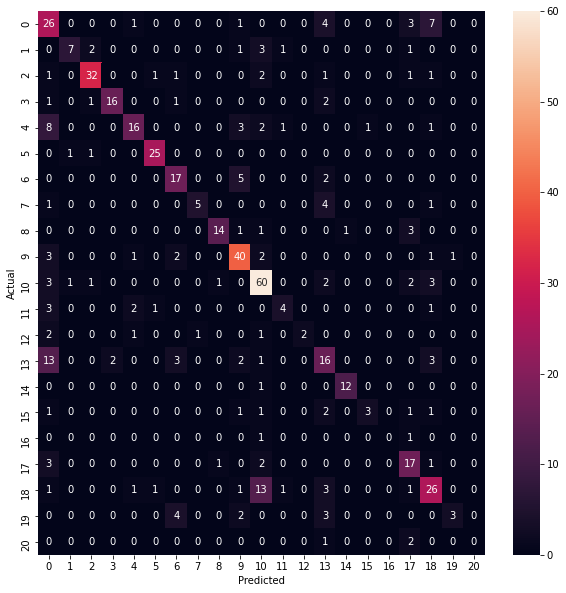


Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  362.130978  | 287.697570 |   11.25   |   4.30   
Validation loss decreased (inf --> 287.697570).  Saving model ...
   2    |  326.828930  | 248.433920 |   30.16   |   4.34   
Validation loss decreased (287.697570 --> 248.433920).  Saving model ...
   3    |  256.617111  | 195.754724 |   47.87   |   4.35   
Validation loss decreased (248.433920 --> 195.754724).  Saving model ...
   4    |  200.849602  | 171.769893 |   48.65   |   4.36   
Validation loss decreased (195.754724 --> 171.769893).  Saving model ...
   5    |  160.545565  | 158.724589 |   50.40   |   4.32   
Validation loss decreased (171.769893 --> 158.724589).  Saving model ...
   6    |  132.474344  | 150.811844 |   55.19   |   4.35   
Validation loss decreased (158.724589 --> 150.811844).  Saving model ...
   7    |  107.502873  | 147.968873 |   55.79   |   4.32   
Validati

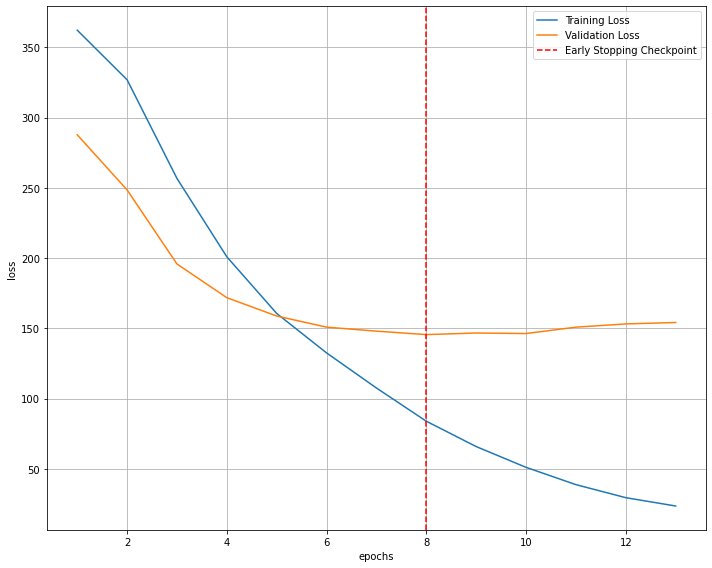

--------------- Fold:  2 ---------------------

              precision    recall  f1-score   support

           0       0.51      0.67      0.58        42
           1       0.42      0.33      0.37        15
           2       0.76      0.88      0.81        40
           3       0.60      0.71      0.65        21
           4       0.58      0.66      0.62        32
           5       0.91      0.78      0.84        27
           6       0.53      0.75      0.62        24
           7       1.00      0.55      0.71        11
           8       0.44      0.35      0.39        20
           9       0.73      0.86      0.79        50
          10       0.57      0.75      0.65        72
          11       0.50      0.09      0.15        11
          12       0.67      0.29      0.40         7
          13       0.45      0.42      0.44        40
          14       0.67      0.46      0.55        13
          15       0.00      0.00      0.00        10
          16       0.00      0.00

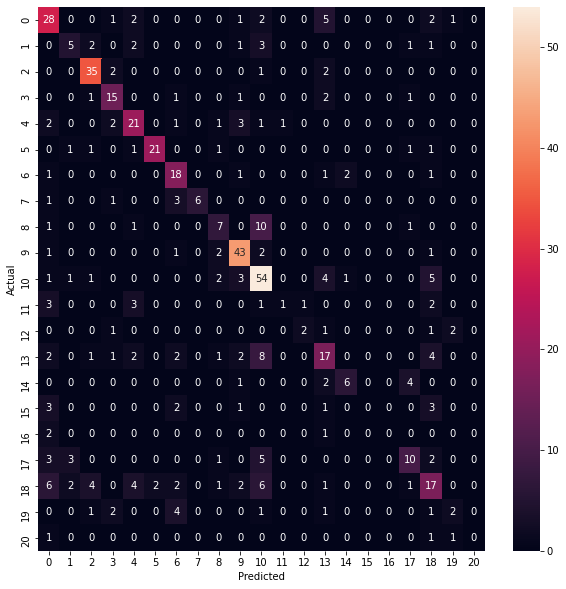


Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  361.488193  | 286.442656 |   13.59   |   4.31   
Validation loss decreased (inf --> 286.442656).  Saving model ...
   2    |  326.477424  | 245.430139 |   29.69   |   4.31   
Validation loss decreased (286.442656 --> 245.430139).  Saving model ...
   3    |  256.849669  | 186.528997 |   50.17   |   4.33   
Validation loss decreased (245.430139 --> 186.528997).  Saving model ...
   4    |  198.819329  | 158.274925 |   55.17   |   4.31   
Validation loss decreased (186.528997 --> 158.274925).  Saving model ...
   5    |  160.143890  | 141.711942 |   59.18   |   4.31   
Validation loss decreased (158.274925 --> 141.711942).  Saving model ...
   6    |  132.557393  | 134.357882 |   60.41   |   4.34   
Validation loss decreased (141.711942 --> 134.357882).  Saving model ...
   7    |  108.601544  | 128.166450 |   61.21   |   4.31   
Validati

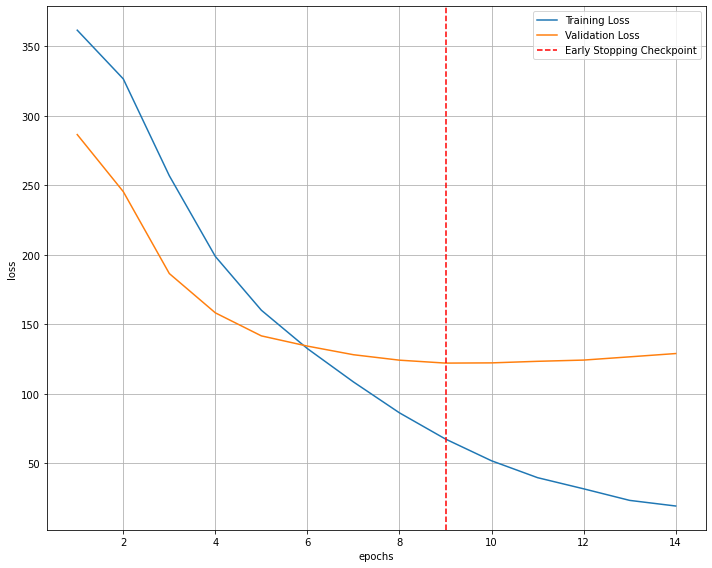

--------------- Fold:  3 ---------------------

              precision    recall  f1-score   support

           0       0.42      0.64      0.51        42
           1       0.67      0.40      0.50        15
           2       0.73      0.90      0.81        40
           3       0.60      0.60      0.60        20
           4       0.57      0.64      0.60        33
           5       0.79      0.79      0.79        28
           6       0.73      0.79      0.76        24
           7       0.55      0.55      0.55        11
           8       0.78      0.70      0.74        20
           9       0.79      0.84      0.82        50
          10       0.72      0.81      0.76        72
          11       1.00      0.27      0.43        11
          12       0.67      0.57      0.62         7
          13       0.30      0.25      0.27        40
          14       0.50      0.46      0.48        13
          15       1.00      0.20      0.33        10
          16       0.00      0.00

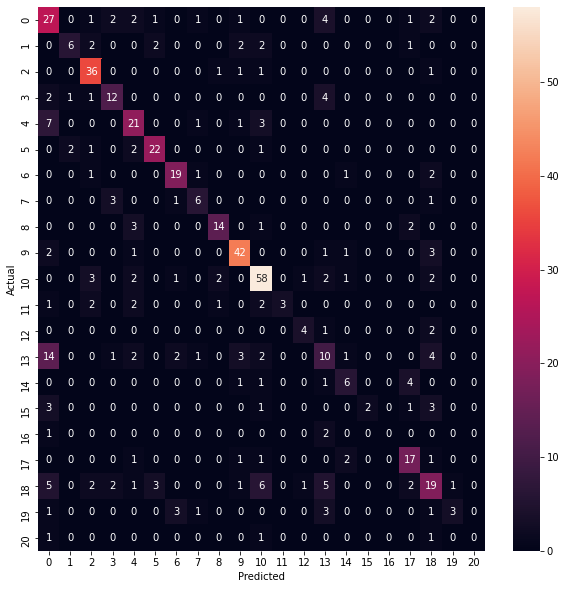


Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  362.282949  | 286.473449 |   14.22   |   4.32   
Validation loss decreased (inf --> 286.473449).  Saving model ...
   2    |  325.690759  | 243.818529 |   31.56   |   4.33   
Validation loss decreased (286.473449 --> 243.818529).  Saving model ...
   3    |  255.580959  | 188.616631 |   49.41   |   4.31   
Validation loss decreased (243.818529 --> 188.616631).  Saving model ...
   4    |  200.344326  | 157.965219 |   55.17   |   4.31   
Validation loss decreased (188.616631 --> 157.965219).  Saving model ...
   5    |  161.935029  | 141.482032 |   58.89   |   4.31   
Validation loss decreased (157.965219 --> 141.482032).  Saving model ...
   6    |  133.447052  | 132.672346 |   61.71   |   4.32   
Validation loss decreased (141.482032 --> 132.672346).  Saving model ...
   7    |  107.451550  | 127.875954 |   64.34   |   4.31   
Validati

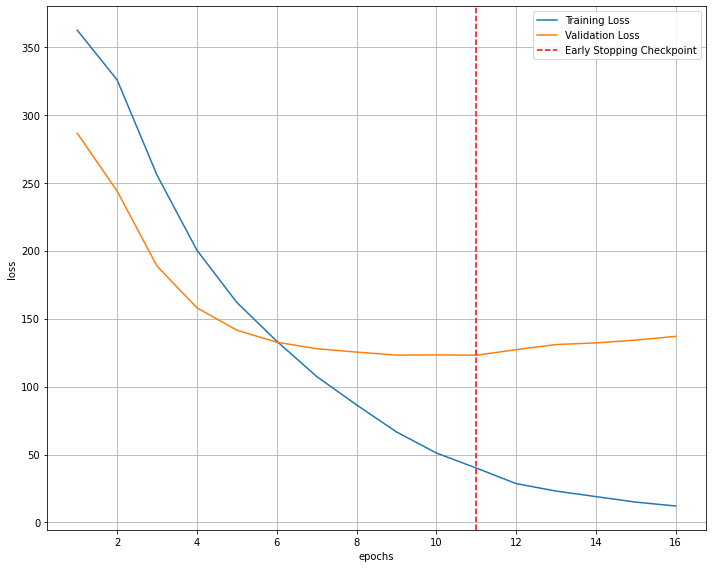

--------------- Fold:  4 ---------------------

              precision    recall  f1-score   support

           0       0.51      0.62      0.56        42
           1       0.69      0.64      0.67        14
           2       0.79      0.78      0.78        40
           3       0.77      0.50      0.61        20
           4       0.50      0.45      0.48        33
           5       0.80      0.86      0.83        28
           6       0.80      0.67      0.73        24
           7       0.71      0.45      0.56        11
           8       0.65      0.75      0.70        20
           9       0.78      0.80      0.79        50
          10       0.70      0.83      0.76        72
          11       0.78      0.64      0.70        11
          12       1.00      0.43      0.60         7
          13       0.44      0.47      0.46        40
          14       0.53      0.77      0.62        13
          15       1.00      0.30      0.46        10
          16       0.50      0.33

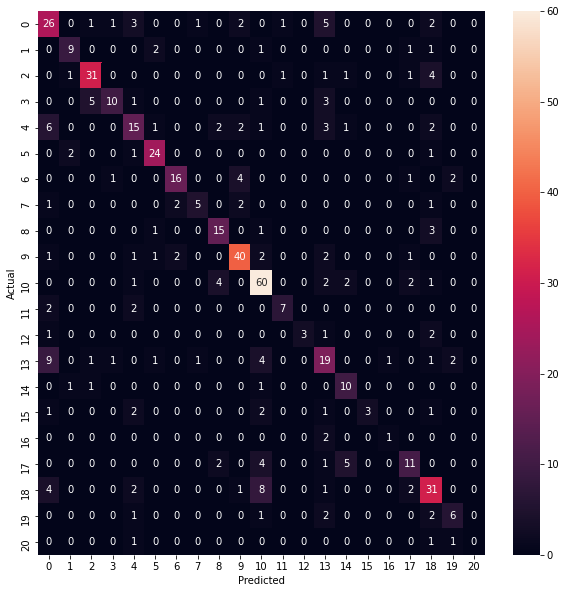


Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  363.304320  | 286.851021 |   11.25   |   4.30   
Validation loss decreased (inf --> 286.851021).  Saving model ...
   2    |  327.974543  | 247.988349 |   33.28   |   4.35   
Validation loss decreased (286.851021 --> 247.988349).  Saving model ...
   3    |  256.760892  | 195.651497 |   41.05   |   4.32   
Validation loss decreased (247.988349 --> 195.651497).  Saving model ...
   4    |  198.497576  | 167.424069 |   52.85   |   4.32   
Validation loss decreased (195.651497 --> 167.424069).  Saving model ...
   5    |  160.768885  | 150.260511 |   56.57   |   4.33   
Validation loss decreased (167.424069 --> 150.260511).  Saving model ...
   6    |  130.692303  | 139.160589 |   60.61   |   4.31   
Validation loss decreased (150.260511 --> 139.160589).  Saving model ...
   7    |  105.079415  | 131.585122 |   61.55   |   4.31   
Validati

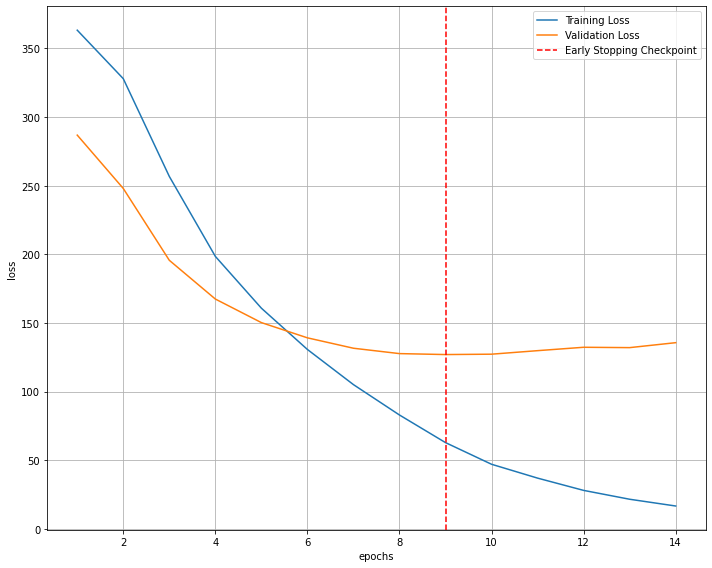

--------------- Fold:  5 ---------------------

              precision    recall  f1-score   support

           0       0.46      0.57      0.51        42
           1       0.60      0.21      0.32        14
           2       0.78      0.78      0.78        40
           3       0.84      0.80      0.82        20
           4       0.59      0.82      0.68        33
           5       0.73      0.86      0.79        28
           6       0.80      0.87      0.83        23
           7       0.70      0.64      0.67        11
           8       0.71      0.50      0.59        20
           9       0.80      0.80      0.80        50
          10       0.58      0.83      0.69        72
          11       0.75      0.27      0.40        11
          12       1.00      0.57      0.73         7
          13       0.59      0.42      0.49        40
          14       0.90      0.64      0.75        14
          15       1.00      0.10      0.18        10
          16       0.00      0.00

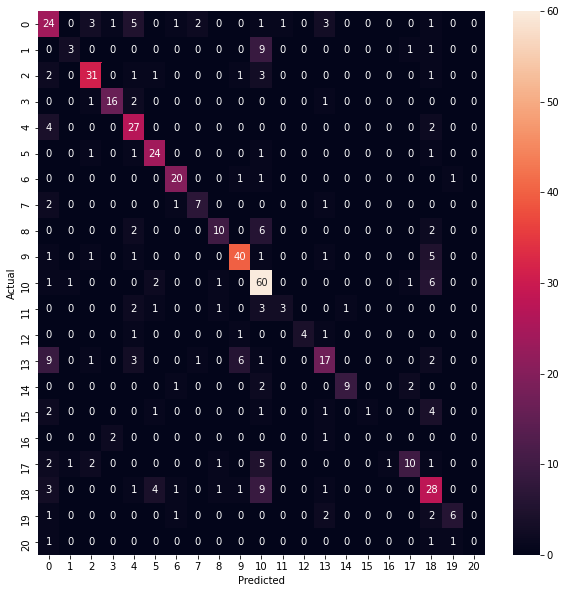


Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  362.501366  | 286.485933 |   11.25   |   4.30   
Validation loss decreased (inf --> 286.485933).  Saving model ...
   2    |  328.377691  | 243.945886 |   34.06   |   4.31   
Validation loss decreased (286.485933 --> 243.945886).  Saving model ...
   3    |  259.175517  | 188.408824 |   50.79   |   4.32   
Validation loss decreased (243.945886 --> 188.408824).  Saving model ...
   4    |  201.680494  | 158.856756 |   58.85   |   4.31   
Validation loss decreased (188.408824 --> 158.856756).  Saving model ...
   5    |  163.084081  | 144.905296 |   59.31   |   4.33   
Validation loss decreased (158.856756 --> 144.905296).  Saving model ...
   6    |  133.009651  | 135.888457 |   59.05   |   4.32   
Validation loss decreased (144.905296 --> 135.888457).  Saving model ...
   7    |  107.486351  | 133.665278 |   60.59   |   4.36   
Validati

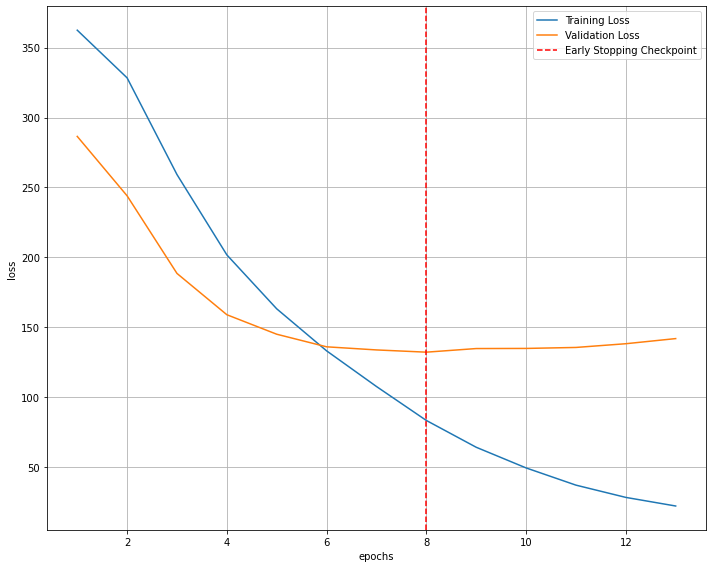

--------------- Fold:  6 ---------------------

              precision    recall  f1-score   support

           0       0.39      0.38      0.39        42
           1       0.31      0.29      0.30        14
           2       0.86      0.95      0.90        40
           3       0.59      0.95      0.73        20
           4       0.58      0.33      0.42        33
           5       0.77      0.74      0.75        27
           6       0.73      0.79      0.76        24
           7       0.70      0.64      0.67        11
           8       0.59      0.85      0.69        20
           9       0.78      0.82      0.80        51
          10       0.72      0.81      0.76        72
          11       0.06      0.09      0.07        11
          12       1.00      0.14      0.25         7
          13       0.37      0.42      0.40        40
          14       0.91      0.71      0.80        14
          15       0.50      0.10      0.17        10
          16       0.00      0.00

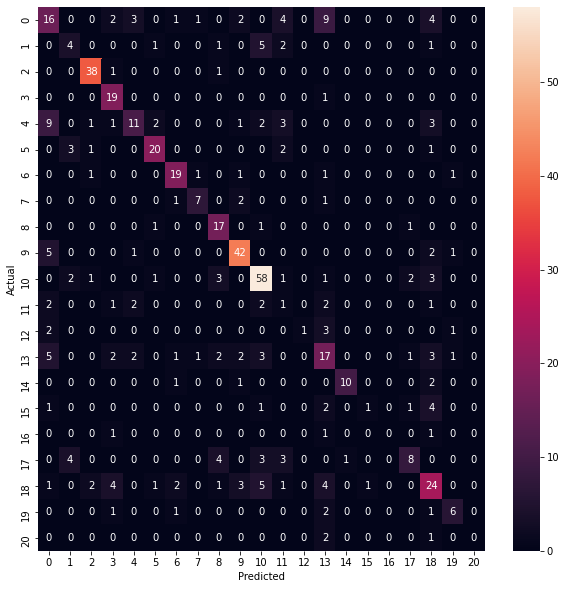


Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  362.078937  | 284.922769 |   11.72   |   4.33   
Validation loss decreased (inf --> 284.922769).  Saving model ...
   2    |  325.339752  | 236.870618 |   33.44   |   4.31   
Validation loss decreased (284.922769 --> 236.870618).  Saving model ...
   3    |  253.209451  | 174.040478 |   53.58   |   4.32   
Validation loss decreased (236.870618 --> 174.040478).  Saving model ...
   4    |  195.615533  | 145.644552 |   57.02   |   4.32   
Validation loss decreased (174.040478 --> 145.644552).  Saving model ...
   5    |  159.055002  | 130.934196 |   60.75   |   4.31   
Validation loss decreased (145.644552 --> 130.934196).  Saving model ...
   6    |  132.313798  | 121.790378 |   62.15   |   4.33   
Validation loss decreased (130.934196 --> 121.790378).  Saving model ...
   7    |  107.355114  | 117.381805 |   63.43   |   4.32   
Validati

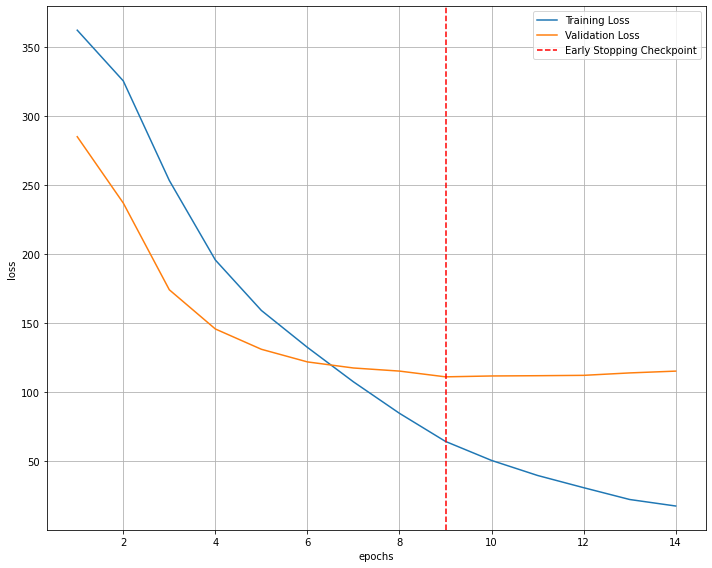

--------------- Fold:  7 ---------------------

              precision    recall  f1-score   support

           0       0.41      0.60      0.49        42
           1       0.40      0.29      0.33        14
           2       0.76      0.78      0.77        41
           3       0.84      0.80      0.82        20
           4       0.52      0.44      0.47        32
           5       0.92      0.85      0.88        27
           6       0.71      0.62      0.67        24
           7       0.62      0.45      0.53        11
           8       0.70      1.00      0.82        21
           9       0.84      0.90      0.87        51
          10       0.78      0.88      0.82        72
          11       1.00      0.18      0.31        11
          12       1.00      0.29      0.44         7
          13       0.60      0.62      0.61        39
          14       0.89      0.62      0.73        13
          15       0.50      0.18      0.27        11
          16       0.00      0.00

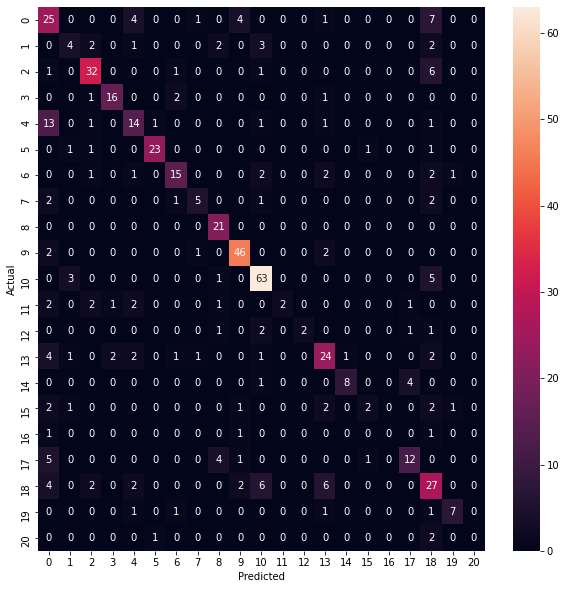


Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  363.215670  | 286.253273 |   11.41   |   4.32   
Validation loss decreased (inf --> 286.253273).  Saving model ...
   2    |  329.136259  | 242.603751 |   33.59   |   4.31   
Validation loss decreased (286.253273 --> 242.603751).  Saving model ...
   3    |  257.552998  | 183.547755 |   48.79   |   4.37   
Validation loss decreased (242.603751 --> 183.547755).  Saving model ...
   4    |  200.071676  | 157.056502 |   54.86   |   4.33   
Validation loss decreased (183.547755 --> 157.056502).  Saving model ...
   5    |  160.541181  | 144.726544 |   57.20   |   4.32   
Validation loss decreased (157.056502 --> 144.726544).  Saving model ...
   6    |  131.069358  | 135.513306 |   59.21   |   4.32   
Validation loss decreased (144.726544 --> 135.513306).  Saving model ...
   7    |  104.659883  | 127.879575 |   61.86   |   4.32   
Validati

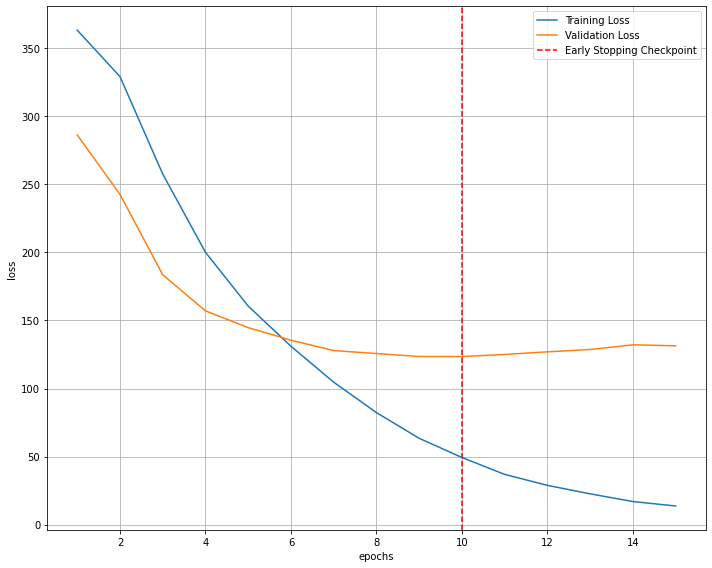

--------------- Fold:  8 ---------------------

              precision    recall  f1-score   support

           0       0.45      0.48      0.47        42
           1       0.50      0.07      0.12        14
           2       0.94      0.83      0.88        41
           3       0.71      0.95      0.82        21
           4       0.54      0.78      0.64        32
           5       0.78      0.93      0.85        27
           6       0.72      0.54      0.62        24
           7       0.75      0.60      0.67        10
           8       0.86      0.86      0.86        21
           9       0.80      0.78      0.79        51
          10       0.82      0.76      0.79        72
          11       0.50      0.50      0.50        10
          12       0.50      0.12      0.20         8
          13       0.39      0.42      0.40        40
          14       0.77      0.77      0.77        13
          15       0.67      0.80      0.73        10
          16       0.50      0.33

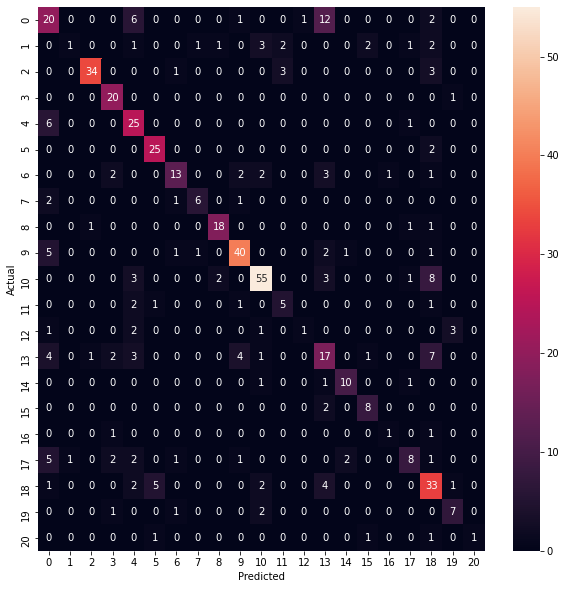


Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  362.642899  | 284.315025 |   11.25   |   4.31   
Validation loss decreased (inf --> 284.315025).  Saving model ...
   2    |  327.296590  | 239.080842 |   32.81   |   4.32   
Validation loss decreased (284.315025 --> 239.080842).  Saving model ...
   3    |  256.194055  | 179.109714 |   52.24   |   4.31   
Validation loss decreased (239.080842 --> 179.109714).  Saving model ...
   4    |  199.119287  | 150.117658 |   54.69   |   4.33   
Validation loss decreased (179.109714 --> 150.117658).  Saving model ...
   5    |  161.474946  | 134.043268 |   60.26   |   4.33   
Validation loss decreased (150.117658 --> 134.043268).  Saving model ...
   6    |  131.420400  | 125.218058 |   61.98   |   4.31   
Validation loss decreased (134.043268 --> 125.218058).  Saving model ...
   7    |  105.274546  | 117.843844 |   64.48   |   4.31   
Validati

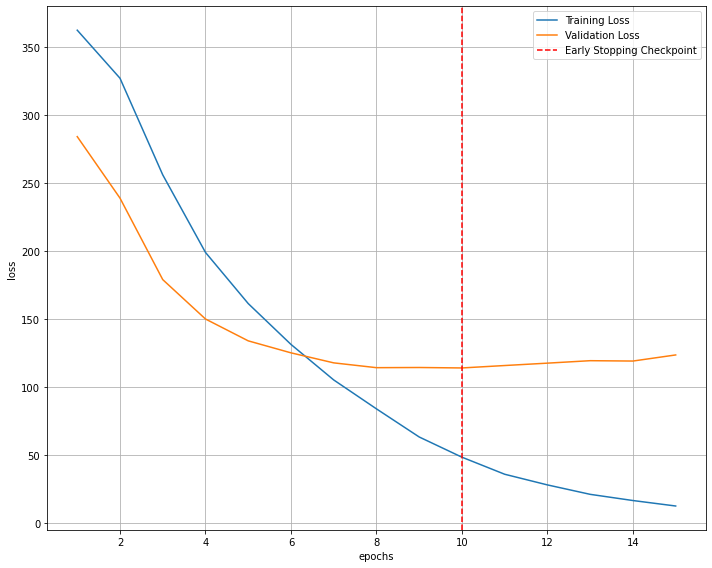

--------------- Fold:  9 ---------------------

              precision    recall  f1-score   support

           0       0.56      0.52      0.54        42
           1       0.50      0.29      0.36        14
           2       0.83      0.83      0.83        41
           3       0.85      0.81      0.83        21
           4       0.68      0.72      0.70        32
           5       0.58      0.81      0.68        27
           6       0.57      0.88      0.69        24
           7       0.86      0.60      0.71        10
           8       0.70      0.76      0.73        21
           9       0.76      0.94      0.84        51
          10       0.76      0.76      0.76        72
          11       0.67      0.20      0.31        10
          12       1.00      0.50      0.67         8
          13       0.50      0.38      0.43        40
          14       0.78      0.54      0.64        13
          15       0.56      0.50      0.53        10
          16       0.00      0.00

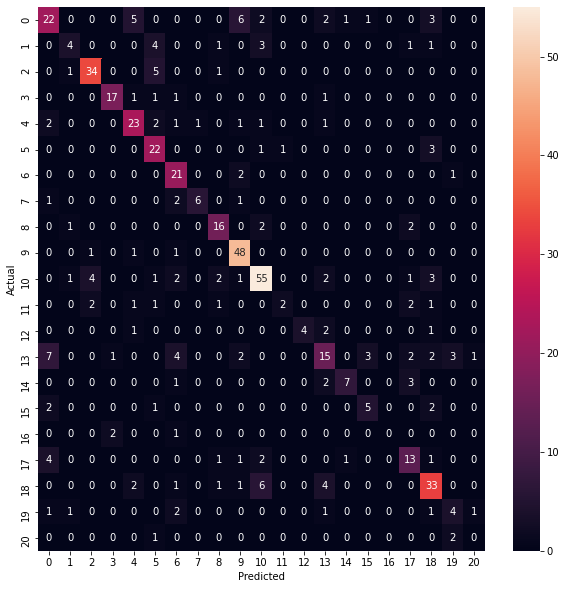


Start training...

 Epoch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------
   1    |  361.823354  | 284.817327 |   13.28   |   4.30   
Validation loss decreased (inf --> 284.817327).  Saving model ...
   2    |  327.134773  | 244.032277 |   38.75   |   4.32   
Validation loss decreased (284.817327 --> 244.032277).  Saving model ...
   3    |  257.250653  | 189.793273 |   52.45   |   4.31   
Validation loss decreased (244.032277 --> 189.793273).  Saving model ...
   4    |  200.690636  | 159.549459 |   57.97   |   4.32   
Validation loss decreased (189.793273 --> 159.549459).  Saving model ...
   5    |  160.396774  | 144.592046 |   61.41   |   4.31   
Validation loss decreased (159.549459 --> 144.592046).  Saving model ...
   6    |  131.414562  | 138.474347 |   63.59   |   4.32   
Validation loss decreased (144.592046 --> 138.474347).  Saving model ...
   7    |  104.231615  | 132.878245 |   65.16   |   4.32   
Validati

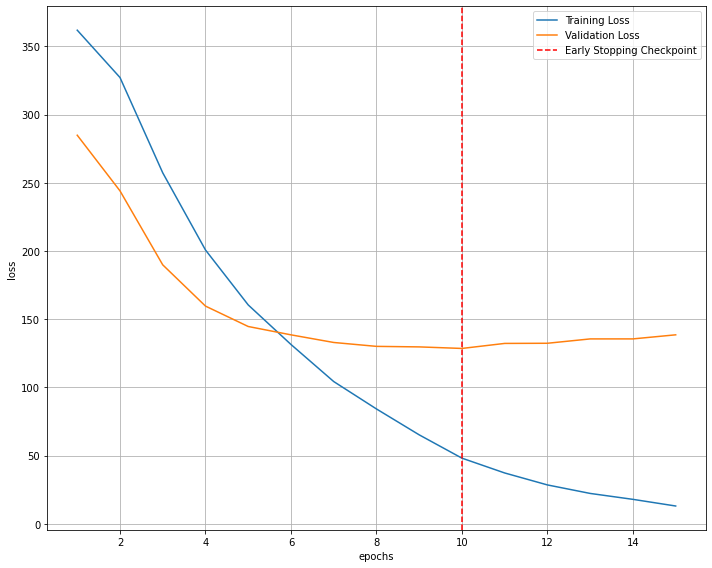

--------------- Fold: 10 ---------------------

              precision    recall  f1-score   support

           0       0.48      0.55      0.51        42
           1       0.29      0.29      0.29        14
           2       0.77      0.85      0.81        40
           3       0.75      0.71      0.73        21
           4       0.73      0.69      0.71        32
           5       0.75      0.78      0.76        27
           6       0.72      0.75      0.73        24
           7       0.60      0.60      0.60        10
           8       0.57      0.80      0.67        20
           9       0.80      0.92      0.85        51
          10       0.69      0.60      0.64        72
          11       0.33      0.20      0.25        10
          12       1.00      0.50      0.67         8
          13       0.46      0.45      0.46        40
          14       0.78      0.54      0.64        13
          15       0.60      0.30      0.40        10
          16       0.00      0.00

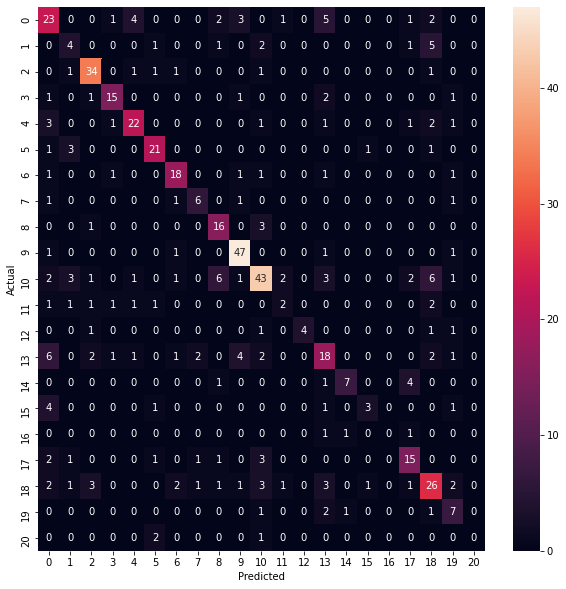

In [194]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
X=encoded_sentences
y=np.array(classes)
kfold = StratifiedKFold(n_splits=nfold).split(X, y)

accuracys = []
scores= []
metriche = np.zeros((nfold,4,n_output))
target_names=np.unique(classes)
#target_names=le.inverse_transform(target_names)

for k, (train_ids, test_ids) in enumerate(kfold):
    
    train_loader, val_loader=create_data_loader(X[train_ids],X[test_ids],y[train_ids],y[test_ids],batch_size)
    
    
    model = ClassificationCNN(
                        pretrained_embedding=embeddings, 
                        n_output=n_output,
                        filter_sizes=filter_sizes,
                        dropout=dropout_pc,
                        n_filters=number_of_filters)
    model=model.double()
    loss_fn = nn.CrossEntropyLoss(reduction='sum').to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    model.to(DEVICE)
    model=train(model,optimizer,loss_fn,train_loader,val_loader,patience,n_epochs)
    
    
    y_pred=pytorch_predict(model,val_loader)
    
    y_true=y[test_ids]
    accuracys.append(metrics.accuracy_score(y_true, y_pred))
    score=precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, labels=target_names, average="weighted")
    scores.append(score[0:3])
    print('--------------- Fold: %2d ---------------------'% (k+1))
    print()
    target_names = list(map(str,target_names))
    print(metrics.classification_report(y_true, y_pred, target_names=target_names))
    dizionario=metrics.classification_report(y_true, y_pred, target_names=target_names,output_dict=True)
    for k_d,(m_id, m_info) in enumerate(dizionario.items()):
        if k_d<n_output:
            for j_d,key in enumerate(m_info):
                metriche[k,j_d,k_d]=m_info[key]
        else:
            break
    
    conf_mat = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=target_names , yticklabels=target_names )
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    print()

arr = np.array(scores)


In [198]:
print("Overall results of the cross-validation procedure")
print()
print(f"{'Class':^7} | {'precision':^9}{'':^6} | {'recall':^10}{'':^5} | {'f1-measure':^6}{'':^5} | {'support':^9}")
for i in range(n_output):
    print(f"{i :^7} | {np.mean(metriche[:,0,i])*100:^5.2f} +/-{np.std(metriche[:,0,i])*100:^6.2f} | {np.mean(metriche[:,1,i])*100:^5.2f} +/-{np.std(metriche[:,1,i])*100:^6.2f} | {np.mean(metriche[:,2,i])*100:^5.2f} +/-{np.std(metriche[:,2,i])*100:^6.2f} | {np.mean(metriche[:,3,i]):^9.2f}")
print()
print('\nCV accuracy: %.2f +/- %.2f max: %.2f' % (np.mean(accuracys)*100, np.std(accuracys)*100,np.max(accuracys)*100))
print('\nCV precision: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,0])*100, np.std(arr[:,0])*100,np.max(arr[:,0])*100))
print('\nCV recall: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,1])*100, np.std(arr[:,1])*100,np.max(arr[:,1])*100))
print('\nCV f1: %.2f +/- %.2f max: %.2f' % (np.mean(arr[:,2])*100, np.std(arr[:,2])*100,np.max(arr[:,2])*100))

Overall results of the cross-validation procedure

 Class  | precision       |   recall        | f1-measure      |  support 
   0    | 45.94 +/- 5.42  | 56.43 +/- 8.18  | 50.28 +/- 5.14  |   42.00  
   1    | 51.47 +/-15.80  | 32.71 +/-14.47  | 38.40 +/-15.01  |   14.30  
   2    | 81.02 +/- 6.13  | 83.64 +/- 5.54  | 82.12 +/- 4.16  |   40.30  
   3    | 74.50 +/-10.82  | 76.02 +/-13.27  | 74.28 +/- 8.86  |   20.50  
   4    | 60.16 +/- 7.85  | 60.24 +/-15.34  | 59.15 +/- 9.60  |   32.40  
   5    | 79.18 +/- 9.66  | 83.15 +/- 6.00  | 80.77 +/- 6.48  |   27.30  
   6    | 69.22 +/- 8.81  | 73.70 +/- 9.97  | 70.64 +/- 6.54  |   23.90  
   7    | 73.25 +/-12.81  | 55.27 +/- 7.05  | 62.27 +/- 6.41  |   10.70  
   8    | 68.67 +/-12.67  | 72.69 +/-17.57  | 69.58 +/-12.58  |   20.30  
   9    | 77.80 +/- 3.67  | 84.73 +/- 5.36  | 81.01 +/- 3.40  |   50.50  
  10    | 70.27 +/- 7.53  | 78.50 +/- 7.24  | 73.79 +/- 5.67  |   72.10  
  11    | 61.58 +/-27.58  | 28.09 +/-16.63  | 35.64 +/-17.08 